In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Looking at Individual Payer 417614
### v2.0

In [2]:
#Shamelessly lifted from Jon's branch
bridge = pd.read_csv("../data/bridge.csv")
dim_claims = pd.read_csv("../data/dim_claims.csv")
dim_date = pd.read_csv("../data/dim_date.csv")
dim_pa = pd.read_csv("../data/dim_pa.csv")

In [3]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()

df4.head(10)
df4[df4.bin == 417614].head(25)

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
14,15,5.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
15,16,6.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
17,18,7.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
19,20,8.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
20,21,9.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
21,22,10.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
22,23,11.0,1,417614,A,70.0,0,1.0,1.0,1.0,1.0
27,28,12.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0
28,29,13.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
29,30,14.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0


In [4]:
mypayer=df4[df4.bin == 417614].copy()

In [5]:
mypayer = mypayer.fillna(-1)
mypayer.shape

(307323, 11)

In [6]:
mypayer.head(10)
#mypayer.reject_code == -1

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
14,15,5.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
15,16,6.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
17,18,7.0,1,417614,A,70.0,0,0.0,1.0,0.0,1.0
19,20,8.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
20,21,9.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
21,22,10.0,1,417614,A,70.0,0,1.0,1.0,0.0,1.0
22,23,11.0,1,417614,A,70.0,0,1.0,1.0,1.0,1.0
27,28,12.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0
28,29,13.0,1,417614,A,70.0,0,1.0,0.0,1.0,0.0
29,30,14.0,1,417614,A,70.0,0,1.0,1.0,0.0,0.0


Do we have any cases where the drug is rejected, but a PA is not requested? The code below demonstrates we do not.

In [7]:
min(mypayer[(mypayer.pharmacy_claim_approved == 0)].dim_pa_id)

5.0

In [8]:
#X = mypayer.drop(columns='pa_approved').copy()
#X.head()
#y = mypayer['pa_approved'].copy()
#y.head(5)


Now, to tackle the question "If a PA is required which features on the PA claim (Correct diagnosis, Tried and failed, Contraindication) help get the PA approved?"

Given what we found above, all or nearly all of the code 75 rejections should be approved with a PA

In [9]:
pa = mypayer[mypayer.pharmacy_claim_approved == 0].copy()
y = pa['pa_approved']

X_train,X_test,y_train,y_test = train_test_split(pa,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

#X_train.head(10)
codes = X_train['reject_code'].unique()
print(codes)
#X_train = X_train[X_train.pharmacy_claim_approved == 0]
#y_train = X_train['pa_approved']


for code in codes:
    if(code != -1): 
        pa_approved = X_train[(X_train.reject_code == code) & (y_train == 1)].shape[0]
        pa_req = X_train[(X_train.reject_code == code) & (X_train.dim_pa_id > 0)].shape[0]
        if(pa_req == 0): 
            app_rate = -99
        else:
            app_rate = pa_approved/pa_req
        print("Reject Code ",code,"has approval rate of ",app_rate)

[70. 75. 76.]
Reject Code  70.0 has approval rate of  0.5817332685637341
Reject Code  75.0 has approval rate of  0.973280051475693
Reject Code  76.0 has approval rate of  0.6401508011310085


In [10]:
X_train.head()


,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
818988,818989,340465.0,712,417614,A,70.0,0,1.0,0.0,1.0,1.0
103917,103918,43031.0,95,417614,B,75.0,0,1.0,1.0,1.0,1.0
1116749,1116750,464193.0,928,417614,A,70.0,0,1.0,0.0,0.0,0.0
697062,697063,289417.0,613,417614,A,70.0,0,1.0,1.0,0.0,1.0
201180,201181,83352.0,191,417614,A,70.0,0,0.0,0.0,0.0,1.0


## Baselining 

What metrics would we measure if we assumed all PAs would be accepted and merged all payers together.

In [11]:
print(df4['pa_approved'].unique())

rejected = df4[(df4.pa_approved == 0)].shape[0]
accepted = df4[(df4.pa_approved == 1)].shape[0]

print(accepted)
print(rejected)

tp = accepted
fp = rejected
fn = tn = 0

a = (tp+tn)/(tp+fp+fn+tn)
p = (tp)/(tp+fp)
r = tp/(tp+fn)
f1 = 2*(p*r)/(p+r)

print("Accuracy is ",np.round(a,5))
print("Precision is ",np.round(p,5))
print("Recall is ",np.round(r,5))
print("F1 is ",np.round(f1,5))

[ 1. nan  0.]
408319
147632
Accuracy is  0.73445
Precision is  0.73445
Recall is  1.0
F1 is  0.8469


## Now, using actual data science methods

In [12]:


#bit_features = ['correct_diagnosis','tried_and_failed','contraindication']
rcd = pd.get_dummies(X_train['reject_code'])
#hot code the rejection codes

rcd.head()
rcd.columns

X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]

#hot code the drugs

X_train['Drug A']=pd.get_dummies(X_train['drug'])['A']
X_train['Drug B']=pd.get_dummies(X_train['drug'])['B']

#X_train.head()
            

<ipython-input-12-e43d4d732711>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
<ipython-input-12-e43d4d732711>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]
<ipython-input-12-e43d4d732711>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [13]:
X_train.head(10)


,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,not_in_formulary,limit_exceeded,Drug A,Drug B
818988,818989,340465.0,712,417614,A,70.0,0,1.0,0.0,1.0,1.0,1,0,1,0
103917,103918,43031.0,95,417614,B,75.0,0,1.0,1.0,1.0,1.0,0,0,0,1
1116749,1116750,464193.0,928,417614,A,70.0,0,1.0,0.0,0.0,0.0,1,0,1,0
697062,697063,289417.0,613,417614,A,70.0,0,1.0,1.0,0.0,1.0,1,0,1,0
201180,201181,83352.0,191,417614,A,70.0,0,0.0,0.0,0.0,1.0,1,0,1,0
1321020,1321021,549867.0,1083,417614,B,75.0,0,1.0,0.0,0.0,1.0,0,0,0,1
1251216,1251217,520632.0,1029,417614,A,70.0,0,1.0,0.0,0.0,0.0,1,0,1,0
933999,934000,388406.0,795,417614,A,70.0,0,1.0,1.0,0.0,1.0,1,0,1,0
241889,241890,100148.0,229,417614,B,75.0,0,1.0,1.0,0.0,1.0,0,0,0,1
1218115,1218116,506650.0,1004,417614,B,75.0,0,1.0,0.0,0.0,1.0,0,0,0,1


In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
features = ['correct_diagnosis','tried_and_failed','contraindication',
           'not_in_formulary','limit_exceeded','Drug A','Drug B']
X_train = X_train[features] 
#X_train = X_train.reset_index(drop=True) #Reset index so the KFold split will work
#y_train = y_train.reset_index(drop=True)
#log_reg = LogisticRegression()
#log_reg.fit(X_train[features],y_train)

#log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
X_train.head()

ti = [23, 22, 27]

X_train.iloc[ti]


,correct_diagnosis,tried_and_failed,contraindication,not_in_formulary,limit_exceeded,Drug A,Drug B
277641,1.0,0.0,0.0,1,0,1,0
30900,1.0,0.0,1.0,1,0,1,0
1078195,0.0,0.0,0.0,1,0,1,0


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# import cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

In [17]:
f = 10
kfold = StratifiedKFold(f,shuffle=True,random_state=440)

In [18]:
cutoffs = np.arange(0.0,1.0,0.02)

accs = np.zeros((f,len(cutoffs)))
precs = np.zeros((f,len(cutoffs)))
recs = np.zeros((f,len(cutoffs)))
f1s = np.zeros((f,len(cutoffs)))

log_reg = LogisticRegression()
tree_clf = DecisionTreeClassifier(random_state = 440)

z=0

#y_prob = log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(len(cutoffs)):
        log_reg_clone = clone(log_reg)
        log_reg_clone.fit(X_train_train,y_train_train)
        probs = log_reg_clone.predict_proba(X_train_test)[:,1]
        
        y_pred = 1*(probs > cutoffs[j])
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

print("Training Done!")

Now training fold 1 of 10
Now training fold 2 of 10
Now training fold 3 of 10
Now training fold 4 of 10
Now training fold 5 of 10
Now training fold 6 of 10
Now training fold 7 of 10
Now training fold 8 of 10
Now training fold 9 of 10
Now training fold 10 of 10
Training Done!


In [19]:
#Gather info for different methods
lpcl = ['Model','Precision','Recall']

lpdf = pd.DataFrame(columns=lpcl)

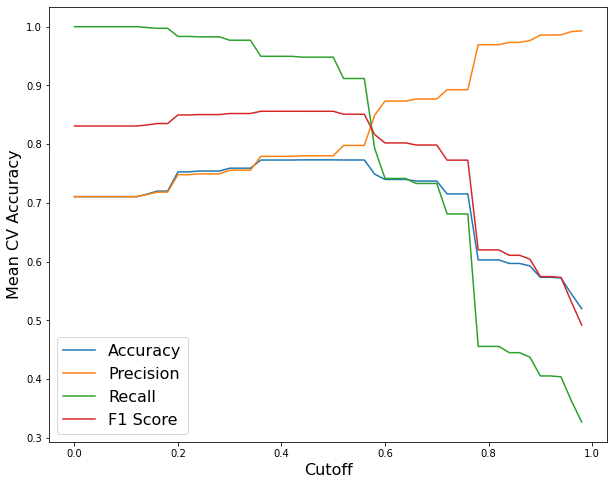

[0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98]
[0.71070055 0.71070055 0.71070055 0.71070055 0.71070055 0.71070055
 0.71070055 0.71417925 0.71834101 0.71839791 0.74805074 0.74805074
 0.74946358 0.74946358 0.74946358 0.7556922  0.7556922  0.7556922
 0.77917873 0.77927641 0.77927641 0.77927641 0.78020047 0.78020047
 0.78020047 0.78020047 0.79781183 0.79781183 0.79781183 0.84943387
 0.87334797 0.87334797 0.87334797 0.87692187 0.87692187 0.87692187
 0.89274028 0.89274028 0.89274028 0.96933838 0.96933838 0.96933838
 0.97328397 0.97328397 0.97636482 0.98580825 0.98580825 0.98612265
 0.99156418 0.99294395]
[0.79291508 0.74163476 0.74163476 0.74163476 0.73312427 0.73312427
 0.73312427 0.68126382 0.68126382 0.68126382 0.45576332 0.45576332
 0.45576332 0.44510781 0.44510781 0.43748786 0.40547486 0.40547486
 0.40393384 0.36314704 0.32701431]
0
Our optimal cutoff at 0.58 gives is a recall of  0.7929 with a precision of 0.8494


In [20]:
plt.figure(figsize=(10,8))

plt.plot(cutoffs,np.mean(accs,axis=0),label="Accuracy")
plt.plot(cutoffs,np.mean(precs,axis=0),label="Precision")
plt.plot(cutoffs,np.mean(recs,axis=0),label="Recall")
plt.plot(cutoffs,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("BasicLogReg.jpg")
plt.show()

prec_guard = 0.8
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]

print(cutoffs[prec>prec_guard])
print(prec)


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = cutoffs[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],4),"gives is a recall of ",np.round(rec2[l],4),
      "with a precision of",np.round(prec2[l],4))

lpdf = lpdf.append(pd.DataFrame([['Logistic Regression',
                                 np.round(prec2[l],4),
                                 np.round(rec2[l],4)]],
                               columns=lpcl))
              


#tmp = pd.DataFrame([[drug,code,ci,cd,tf,frac]],columns=cl)
#pa_df = pa_df.append(tmp,ignore_index = True)

Using a cutoff of 0.5, which seems reasonable given what we found above, let's see if we can determine how the features affect the outcome.

In [ ]:
log_reg_T = LogisticRegression()
log_reg_T.fit(X_train,y_train)

In [ ]:
betas = log_reg_T.coef_
betas.shape

for i in range(0,betas.shape[1]):
    print("Changing ",X_train.iloc[:,i].name," from 0 to 1 multiplies the odds of being accepted by "+
          str(np.round(np.exp(1*log_reg_T.coef_[0][i]),2)))
    
#      " the odds of being classified as accepted by " + 
#      str(np.round(np.exp(1*log_reg_T.coef_[0][0]),2)))

#print("A 1 unit increase in our feature multiplies" + 
#      " the odds of being classified as accepted by " + 
#      str(np.round(np.exp(1*log_reg_T.coef_[0][0]),2)))



In [ ]:
# Grid search of probabilities

print(codes)
drugs=X_train.drug.unique()
print(drugs)

In [ ]:
jb = [0,1]

combs = 3*3*8
zc = 0
cl = ['drug','code','CI','CD','TF','approval rate']

pa_df = pd.DataFrame(columns=cl)

for drug in drugs:
    for code in codes:
        for ci in jb: #'contraindication'
            for cd in jb: #correct diagnosis
                for tf in jb: #tried_and_failed
                    dd = X_train[(X_train.drug == drug) & (X_train.reject_code == code) & (X_train.contraindication == ci)
                                   & (X_train.correct_diagnosis == cd) & (X_train.tried_and_failed == tf)]
                    denom = dd.shape[0]
                    if(denom == 0): 
                        #print("No Requests match this combination -- Drug: ", drug, "reject code", code,
                           #  "Contraindication = ",ci,"correct diagnosis =",cd,"Tried and Failed = ",tf)
                        zc = zc+1
                    else:
                        num = dd[dd.pa_approved == 1].shape[0]
                        frac = num/denom
                        print(frac)
                        tmp = pd.DataFrame([[drug,code,ci,cd,tf,frac]],columns=cl)
                        pa_df = pa_df.append(tmp,ignore_index = True)
                        
                        
print(zc,"out of ",combs,"combinations have no PA requests")
        
        

In [ ]:
pa_df.head(72-48)

In [ ]:
#Try a decision tree
m = 10
maxdepth = range(1,m+1)

accs = np.zeros((f,len(maxdepth)))
precs = np.zeros((f,len(maxdepth)))
recs = np.zeros((f,len(maxdepth)))
f1s = np.zeros((f,len(maxdepth)))


z=0

#y_prob = log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(1,m):
        tree = DecisionTreeClassifier(max_depth=j, random_state = 440)
        fig = tree.fit(X_train_train,y_train_train)
        
        y_pred = tree.predict(X_train_test)
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(maxdepth,np.mean(accs,axis=0),label="Accuracy")
plt.plot(maxdepth,np.mean(precs,axis=0),label="Precision")
plt.plot(maxdepth,np.mean(recs,axis=0),label="Recall")
plt.plot(maxdepth,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("BasicDecTree.jpg")
plt.show()

print(np.max(np.mean(precs,axis=0)))


In [ ]:
plt.figure(figsize = (20,20))


from sklearn import tree as t

t.plot_tree(fig,filled = True,fontsize=12)
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
depth_limit = 20
print(depth_limit)

CV_acc = np.empty((f,depth_limit))
prec = np.empty((f,depth_limit))
recall = np.empty((f,depth_limit))


## Perform kfold cross validation here for max depth or 
## min_samples_split here
fold =0

for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)
    for md in range(1,depth_limit+1):
        dec_tree = RandomForestClassifier(max_depth=md,random_state=440)
        dec_tree.fit(X_train_train,y_train_train)
        y_pred = dec_tree.predict(X_train_test)
        CV_acc[fold,md-1] = accuracy_score(y_train_test,y_pred)
        prec[fold,md-1] = precision_score(y_train_test,y_pred)
        recall[fold,md-1] = recall_score(y_train_test,y_pred)
    fold=fold+1
    
print("Training Done!")


In [ ]:
plt.figure(figsize=(10,8))

xd = range(1,depth_limit+1)

plt.plot(xd,np.mean(prec,axis=0),label="Precision")
plt.plot(xd,np.mean(recall,axis=0),label="Recall")
plt.plot(xd,np.mean(CV_acc,axis=0),label="CV Accuracy")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Scores", fontsize=16)

plt.legend(fontsize=16)

plt.show()

prec_guard = 0.8
prec_mean = np.mean(prec,axis=0)
prec2 = prec_mean[prec_mean>prec_guard]
rec2 = np.mean(recall,axis=0)[prec_mean>prec_guard]

print(xd)
#print(prec)


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = xd[np.mean(prec,axis=0)>prec_guard]

print("Our optimal cutoff at",np.round(xd[l],2),"gives is a recall of ",np.round(rec2[l],2),
      "with a precision of",np.round(prec2[l],2))

lpdf = lpdf.append(pd.DataFrame([['Logistic Regression',
                                 np.round(prec2[l],3),
                                 np.round(rec2[l],3)]],
                               columns=lpcl))

In [ ]:
lpdf.head()

## $k$-Nearest Neighbors


In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
max_neighbors = 20

mn = np.arange(1,max_neighbors,1)

accs = np.zeros((f,len(mn)))
precs = np.zeros((f,len(mn)))
recs = np.zeros((f,len(mn)))
f1s = np.zeros((f,len(mn)))

## keep track of the train test split
j = 0


for train_index, test_index in kfold.split(X_train,y_train):
    # Get the cv train test split
    X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    print("Now training fold",j+1,"of",f)
    for i in range(0,len(mn)):
        knn = KNeighborsClassifier(mn[i])
        print("Fitting with ",mn[i],"neighbors")
        # fit the model
        knn.fit(X_train_train, y_train_train.ravel())
        y_pred = knn.predict(X_train_test)
        accs[j,i-1] = accuracy_score(y_train_test,y_pred)
        precs[j,i-1] = precision_score(y_train_test,y_pred)
        recs[j,i-1] = recall_score(y_train_test,y_pred)
        
    j=j+1

Now training fold 1 of 10
Fitting with  1 neighbors
Fitting with  2 neighbors
Fitting with  3 neighbors
Fitting with  4 neighbors
Fitting with  5 neighbors
Fitting with  6 neighbors
Fitting with  7 neighbors
Fitting with  8 neighbors
Fitting with  9 neighbors
Fitting with  10 neighbors
Fitting with  11 neighbors
Fitting with  12 neighbors
Fitting with  13 neighbors
Fitting with  14 neighbors
Fitting with  15 neighbors
Fitting with  16 neighbors
Fitting with  17 neighbors
Fitting with  18 neighbors
Fitting with  19 neighbors
Now training fold 2 of 10
Fitting with  1 neighbors
Fitting with  2 neighbors
Fitting with  3 neighbors
Fitting with  4 neighbors
Fitting with  5 neighbors
Fitting with  6 neighbors
Fitting with  7 neighbors
Fitting with  8 neighbors
Fitting with  9 neighbors
Fitting with  10 neighbors
Fitting with  11 neighbors
Fitting with  12 neighbors
Fitting with  13 neighbors
Fitting with  14 neighbors
Fitting with  15 neighbors
Fitting with  16 neighbors
Fitting with  17 neig

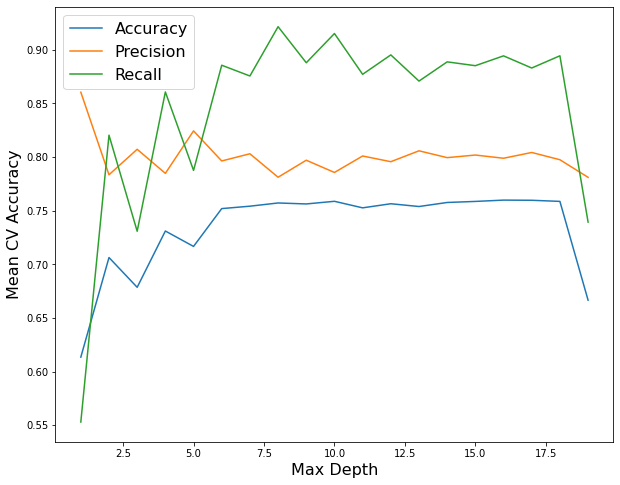

Precision: [0.8604759  0.78348795 0.8072352  0.78479461 0.82437944 0.79635172
 0.80305954 0.78117373 0.79704353 0.78563308 0.80098243 0.79566163
 0.80581493 0.79945144 0.8018724  0.79887775 0.80426316 0.79749995
 0.78108545]
[0.55293206 0.73081742 0.78756508 0.87558169 0.87713827 0.87082716
 0.88517565 0.88301532]
6
Our optimal cutoff at 15 gives is a recall of  0.885 with a precision of 0.802
Depth:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Precision:  [0.8604759  0.78348795 0.8072352  0.78479461 0.82437944 0.79635172
 0.80305954 0.78117373 0.79704353 0.78563308 0.80098243 0.79566163
 0.80581493 0.79945144 0.8018724  0.79887775 0.80426316 0.79749995
 0.78108545]
Recall:  [0.55293206 0.82039244 0.73081742 0.86068165 0.78756508 0.88561006
 0.87558169 0.9215478  0.8879248  0.91515911 0.87713827 0.89524274
 0.87082716 0.8887457  0.88517565 0.89435244 0.88301532 0.89440637
 0.7393584 ]


In [25]:
plt.figure(figsize=(10,8))

plt.plot(mn,np.mean(accs,axis=0),label="Accuracy")
plt.plot(mn,np.mean(precs,axis=0),label="Precision")
plt.plot(mn,np.mean(recs,axis=0),label="Recall")
#plt.plot(cutoffs,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("LukePayer_kNN.jpg")
plt.show()

prec_guard = 0.8
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]

#print(cutoffs[prec>prec_guard])
print("Precision:", prec)


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = mn[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],3),"gives is a recall of ",np.round(rec2[l],3),
      "with a precision of",np.round(prec2[l],3))


print("Depth: ",mn) 
print("Precision: ",prec)
print("Recall: ",rec)

In [ ]:
lpdf = lpdf.append(pd.DataFrame([['kNN',
                                 np.round(prec2[l],3),
                                 np.round(rec2[l],3)]],
                               columns=lpcl))